In [2]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

# 第五章 图像分类

先来个数据集

In [3]:
path = untar_data(URLs.PETS)
Path.BASE_PATH=path
path.ls()

(#2) [Path('annotations'),Path('images')]

再说件重要的事情，大部分的fastai库中的函数都不会返回一个python列表，而是返回一个叫“L”的类，基本可以被认为是一个增强型的 list类型，主要是加了一些操作

In [4]:
#(path/"images").ls()
fname = (path/"images").ls()[0]
re.findall(r'(.+)_\d+.jpg$', fname.name)

['Abyssinian']

In [15]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images",num_workers=0)

最下面两行代码做的是一件叫persizing的工作，首先是将一张图片的内容里面截出固定大小的图片，比如460*460，第二步就是将这个得到的结果做一些旋转，拉伸和缩放，最后再转化成一个标准的矩形，这在CV中是挺重要的一个数据预处理的方式

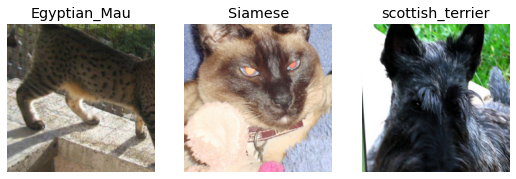

In [6]:
dls.show_batch(nrows=1, ncols=3)

In [16]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.537068,0.299785,0.096752,02:15
1,0.327461,0.203549,0.067659,02:12


如果调用summary函数的话就可以看到具体的处理信息，是一个非常好用的调试工具

In [7]:
pets1 = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'))
pets1.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      C:\Users\94323\.fastai\data\oxford-iiit-pet\images\saint_bernard_138.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x375
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      C:\Users\94323\.fastai\data\oxford-iiit-pet\images\saint_bernard_138.jpg
    applying partial gives
      saint_bernard
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(30, dtype=torch.int32)

Final sample: (PILImage mode=RGB size=500x375, TensorCategory(30, dtype=torch.int32))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {

RuntimeError: stack expects each tensor to be equal size, but got [3, 375, 500] at entry 0 and [3, 199, 300] at entry 1

## 交叉熵损失函数


这个函数是上一章用过的函数，主要有两个好处：
- 在自变量两个以上的情况下也能使用
- 更快

先来看下我们要了解的实际的数据和激活所看到的损失函数的样子。

In [9]:
x,y = dls.one_batch()

In [10]:
y

TensorCategory([36,  8, 14, 18, 33, 33, 21, 35,  7, 35,  5, 28, 17,  1, 25, 35, 33, 35, 31, 19,  1,  1, 13, 13, 24,  0, 25, 23, 15, 13, 36, 16, 27, 12,  1, 16,  5, 10, 16, 27, 13, 14, 12, 16, 28,  3, 27,  8,
        17, 11, 20, 11, 20, 24, 10,  2, 28, 19,  8, 26, 34, 34, 13, 18], device='cuda:0', dtype=torch.int32)

这个是因变量，说明有64个类别，接下来我们看看预测值，也就是神经网络最后一层的值

In [17]:
preds,_ = learn.get_preds(dl=[(x,y)])
preds[0]

我们可以看到在最后第二个的概率比较高，有0.84左右，说明测试集第一张图片很可能是倒数第二个的类别。我们把这些概率相加，看看结果

In [18]:
len(preds[0]),preds[0].sum()

(37, tensor(1.0000))

概率和为1，这个就很正常，但是有时候训练出来的概率和不是1，这就很奇怪，这时候我们需要个叫sotfmax的函数来做激活函数，可以解决这个问题，这个函数是sigmoid的变体

对于一个二分问题来说，步骤大概这样：  
1. 原结果出来  
2. 使用sigmoid函数将结果转为正数  
3. 将第一列和第二列的值做差  
4. 对差值进行sigmoid函数转为正数，这样得到的第一列的结果  
5. 第二列需要用1-第一列的数  

In [21]:
#hide
torch.random.manual_seed(42);
acts = torch.randn((6,2))*2
acts                        #原结果

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

In [22]:
acts.sigmoid()              #第二步

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

In [24]:
diff=(acts[:,0]-acts[:,1]).sigmoid() #第三步和第四步

In [25]:
torch.stack([diff,1-diff],dim=1)    #第五步

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

对于多元的情景，softmax函数使用的是e的次方来进行归一化，举个例子

<img alt="Bear softmax example" width="280" id="bear_softmax" caption="Example of softmax on the bear classifier" src="images/att_00062.png">

原理是上面这样，下面的是定义

In [ ]:
def softmax(x): return exp(x) / exp(x).sum(dim=1, keepdim=True)

简单说，softmax函数就是要得到一个概率和等于1的结果，但是这个函数在处理多元的时候（大于2）有个小缺点，由于用的是e的次方进行运算，有时候处理前的数据可能差一点点，但是在处理之后他们的概率就相差很大了。

虽然有点小缺点，但是它还是最最常用的一种激活函数了。

## 使用log函数

相反的，如果需要将0-1之间的值转换到负无穷大到正无穷，则使用的是e的次方的反函数，log函数

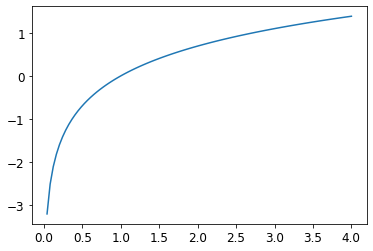

In [26]:
plot_function(torch.log,min=0,max=4)

交叉熵crossentropyloss，就是先用softmax函数，再用log函数，得到的结果就是这个交叉熵，在pytorch里面，先用log_softmax函数后用nll_loss函数得出来的结果，就是交叉熵，在fastai中直接`nn.CrossEntropyLoss()`就好了

## 模型的解释和改进

衡量模型优缺点的方式第一个是混淆矩阵。我们来看看这个猫狗分类器的混淆矩阵

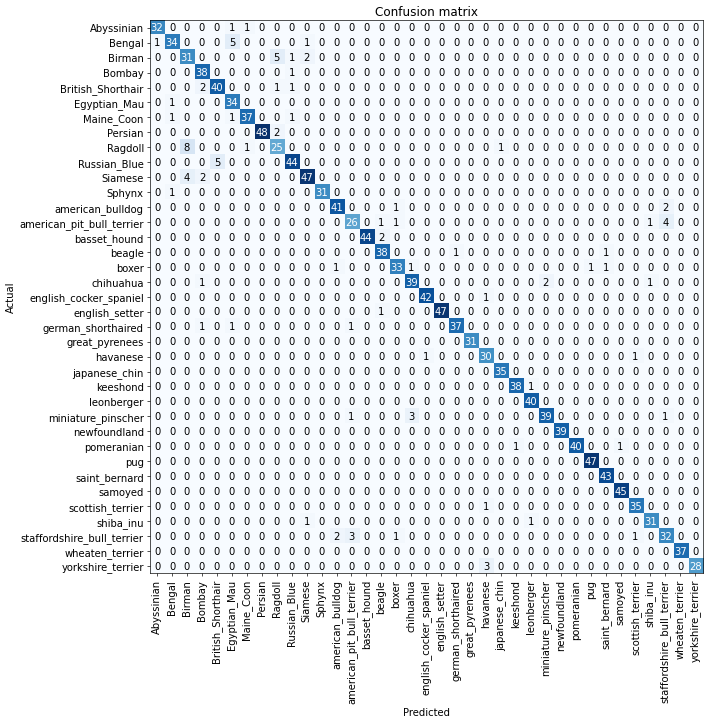

In [28]:
#width 600
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

也可以用模型总结的方式来看看哪里问题出的最多

In [29]:
interp.most_confused(min_val=5)

[('Ragdoll', 'Birman', 8),
 ('Bengal', 'Egyptian_Mau', 5),
 ('Birman', 'Ragdoll', 5),
 ('Russian_Blue', 'British_Shorthair', 5)]

接下来我们看看有什么方式来改进这个模型

### 找到更好的学习率

首先可以先试一下更高的学习率，使用`find_tune`函数来设置模型有更高的学习率，默认的学习率是1e-2

In [30]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,3.153153,1.774306,0.514208,9:43:43


为了找到一个更好的学习率，可以使用学习率查找器

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find()

我们可以很清楚的发现在学习率很小的时候，loss基本没有下降，这是因为每次移动的步长太小了，还没达到局部最优点就迭代结束了，同样的这张图展示了一个趋势，一个倒U型曲线。说明还是有个局部最优点能够找到极值